In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
test_path = 'gdrive/My Drive/Colab Notebooks/NoahTrim_Proper.csv'

from sklearn.model_selection import train_test_split
import pandas as pd
import glob

from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 7
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
import math
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
import plotly.express as px

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = 'gdrive/My Drive/Colab Notebooks/'
all_files = {

   
   "p1": "p1_ostacle.csv"
   

}

li = []

for alias in all_files:
    temp_df = pd.read_csv(path+all_files[alias], index_col=None, header=0)
    temp_df["file_id"] = alias
    li.append(temp_df)

    kp_names = [
      'nose',
      'left_eye',
      'right_eye',
      'left_ear',
      'right_ear',
      'left_shoulder',
      'right_shoulder',
      'left_elbow',
      'right_elbow',
      'left_wrist',
      'right_wrist',
      'left_hip',
      'right_hip',
      'left_knee',
      'right_knee',
      'left_ankle',
      'right_ankle',
    ]

    colnames = []
    for cam in ["back", "side"]:
      for i in kp_names:
        for pt in ["x", "y", "z"]:
          colnames.append(f"{cam}_{i}_{pt}")
    colnames = ["frame_count"] + colnames + ["label", "file_id"]
    temp_df.columns = colnames

df = pd.concat(li, axis=0, ignore_index=True)
dftest = df.apply(lambda x : True
            if x['label'] == 1 else False, axis = 1)

num_rows = len(dftest[dftest == True].index)

print(num_rows)
df

In [ ]:
X = df[[c for c in df.columns if c not in ("frame_count","label", "file_id")]]
y = df["label"]

In [ ]:
def calcAngle(x1,y1,x2,y2):
  angles = []
  for i in range(len(x1)):
    angles.append(math.atan2(y2[i] - y1[i], x2[i] - x1[i]) * 180/math.pi)
  return angles

class FeatureEngineeringTransformer():
  def __init__(self):
    self.angles_joints = {
        'left_torso': ('left_hip','left_shoulder'),
        'right_torso': ('right_hip','right_shoulder'),
        'left_ulna': ('left_wrist','left_elbow'),
        'right_ulna': ('right_wrist','right_elbow'),
        'left_los': ('left_eye','nose'),#line of sight
        'right_los': ('right_eye','nose')
    }

  def fit(self,x, y=None):
    return self

  def transform(self,x):
    for angle in self.angles_joints:
      joint1, joint2 = self.angles_joints[angle]
      x[f'back_{angle}_angle'] = calcAngle(
          x1 = x[f'back_{joint1}_x'].values,
          y1 = x[f'back_{joint1}_y'].values,
          x2 = x[f'back_{joint2}_x'].values,
          y2 = x[f'back_{joint2}_y'].values
      )
      x[f'side_{angle}_angle'] = calcAngle(
          x1 = x[f'side_{joint1}_x'].values,
          y1 = x[f'side_{joint1}_y'].values,
          x2 = x[f'side_{joint2}_x'].values,
          y2 = x[f'side_{joint2}_y'].values
      )
    return x

class FeatureSelectionTransformer():
  def __init__(self, mode):
    self.mode = mode
  
  def fit(self,x, y=None):
    return self
  
  def transform(self, x, y=None):
    if self.mode == "back":
      cols_to_drop = [c for c in x.columns if "side_" in c]
    elif self.mode == "side":
      cols_to_drop = [c for c in x.columns if "back_" in c]
    elif self.mode == "combined":
      cols_to_drop = []
    
    x = x[[c for c in x.columns if c not in cols_to_drop]]
    return x


In [ ]:
with open('gdrive/My Drive/Colab Notebooks/pipelines/back_engFalse_NN.pkl', 'rb') as file:
        model_side = pickle.load(file)


In [ ]:
y_pred = model_side.predict(X.copy())

accuracy_score(y, y_pred)


0.9608482871125612

In [ ]:
with open('gdrive/My Drive/Colab Notebooks/Pipelines_Latest/back_engTrue_LR.pkl', 'rb') as file:
        model_side = pickle.load(file)

In [ ]:
y_pred = model_side.predict(X.copy())
accuracy_score(y_pred, y)

0.9306688417618271

[[657   0]
 [569   0]]


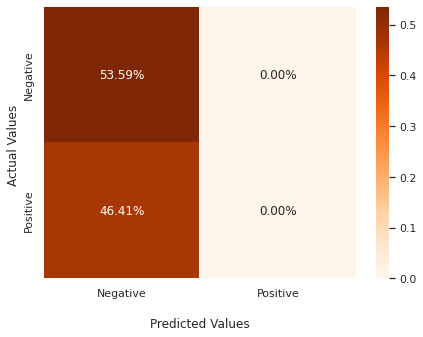

In [ ]:
y_predtest = model_side.predict(X.copy()) 
cf_matrix = confusion_matrix(y, y_predtest)
print(cf_matrix)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Oranges')
#ax.set_title('combined_engFalse_LR\n\n obstacle dataset');
#sns.set(rc = {'figure.figsize':(7,5)})
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()



In [ ]:
y_predtest = model_side1.predict(X.copy()) 
#y_pred = model_side.predict(X)
accuracy = accuracy_score(y, y_predtest)

y_pred_proba = model_side1.predict_proba(X.copy)[::,1]

fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)

plt.plot(fpr,tpr,label="RF AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

AttributeError: ignored

In [ ]:
with open('gdrive/My Drive/Colab Notebooks/Pipelines_Latest/back_engTrue_LR.pkl', 'rb') as file:
        model_side = pickle.load(file)

In [ ]:
y_pred = model_side.predict(X.copy())
accuracy_score(y_pred, y)

0.5383360522022839

In [ ]:
with open('gdrive/My Drive/Colab Notebooks/Pipelines_Latest/back_engTrue_SVM.pkl', 'rb') as file:
        model_side = pickle.load(file)

In [ ]:
y_pred = model_side.predict(X.copy())
accuracy_score(y_pred, y)

0.2528548123980424